### Generate RF Features
- notebook to load data (DroneDetect, DroneRF, our data)
- generate RF-based features: PSD, 

#### To dos:
- spectrogram
- raw IQ plots


In [1]:
import os
import numpy as np
from numpy import sum,isrealobj,sqrt
from numpy.random import standard_normal
import os
from sklearn.model_selection import train_test_split
from spafe.features.lfcc import lfcc
import spafe.utils.vis as vis
from scipy.signal import get_window
import scipy.fftpack as fft
from scipy import signal
import matplotlib.pyplot as plt
from datetime import date

In [2]:
# Data paths

# 1. DroneDetect
main_folder = '/home/ltindall/data/DroneDetect/DroneDetect_V2/' # data path on mp-gpu-desktop06
sub_folders = os.listdir(main_folder)

# Dataset Info
fs = 60e6 #60 MHz
bandwidth = 20e6 # 28MHz
center_freq = 2.43e9

# 2. DroneRF
# main_folder = '/Users/kzhou/Documents/DroneRF Data/All/converted/'
# high_freq_files = os.listdir(data_folder+'High/')
# low_freq_files = os.listdir(data_folder+'Low/')

# high_freq_files.sort()
# low_freq_files.sort()
# fs = 40e6 #40 MHz


# 3. Collected Data
# main_folder = '/home/kzhou/Data/S3/'
# subfolders = ['leesburg_worker1', 'pdx_worker1']
# TODO: how to load this


In [3]:
# Load data for Drone Detect
def load_data(file_path):
    f = open(file_path, "rb")                                        # open file
    data = np.fromfile(f, dtype="float32",count=240000000)      # read the data into numpy array
    data = data.astype(np.float32).view(np.complex64)           # view as complex
    data_norm = (data-np.mean(data))/(np.sqrt(np.var(data)))    # normalise
    newarr = np.array_split(data_norm, 100)	                    # split the array, 100 will equate to a sample length of 20ms
    return newarr, data_norm

In [ ]:
# Labels & Features
DRONES = []
CONDS =[]
INTS = [] # interferences: 00 for a clean signal, 01 for Bluetooth only, 10 for Wi-Fi only and 11 for Bluetooth and Wi-Fi interference concurrently.

# features
F_PSD = []
F_PSD_freq = []

F_SPEC = []
F_SPEC_freq = []
F_SPEC_time = []

n_per_seg = 1024 # length of each segment (powers of 2)
win_type = 'hamming' # make ends of each segment match


# loop through all files
for sf in sub_folders:
    drone_folders = os.listdir(main_folder+sf+'/')
    print('current folder: ', sf)
    for df in drone_folders:
        print('     subfolder:', df)
        files = os.listdir(main_folder+sf+'/'+df+'/')
        for fi in files:
            d_split, _ = load_data(main_folder+sf+'/'+df+'/'+fi)
            for i in range(len(d_split)): # 100 split samples of 20 milliseconds each
                d_real = abs(d_split[i])

                # save labels
                DRONES.append(df[:3])
                CONDS.append(df[4:])
                INTS.append(fi[4:6])

                # calculate PSD
                f, Pxx_den = signal.welch(d_real, fs, window=win_type, nperseg=n_per_seg)
                F_PSD.append(Pxx_den)
                F_PSD_freq.append(f)

                # calculate spectrogram
                f, t, Sxx = signal.spectrogram(d_real, fs, window=win_type, nperseg=n_per_seg)
                F_SPEC.append(Sxx)
                F_SPEC_freq.append(f)
                F_SPEC_time.append(t)
            

current folder:  WIFI
     subfolder: AIR_FY
     subfolder: MP1_ON
     subfolder: MIN_FY
     subfolder: PHA_FY
     subfolder: MP2_ON
     subfolder: MIN_HO
     subfolder: AIR_HO
     subfolder: MP1_FY
     subfolder: DIS_FY
     subfolder: MIN_ON
     subfolder: DIS_ON
     subfolder: INS_FY
     subfolder: INS_HO
     subfolder: MP2_FY
     subfolder: MP1_HO
     subfolder: MP2_HO
     subfolder: PHA_ON
     subfolder: PHA_HO
     subfolder: INS_ON
     subfolder: AIR_ON
current folder:  BLUE
     subfolder: AIR_FY
     subfolder: MP1_ON
     subfolder: MIN_FY
     subfolder: PHA_FY
     subfolder: MP2_ON
     subfolder: MIN_HO
     subfolder: AIR_HO
     subfolder: MP1_FY
     subfolder: DIS_FY
     subfolder: MIN_ON
     subfolder: DIS_ON
     subfolder: INS_FY
     subfolder: INS_HO
     subfolder: MP2_FY
     subfolder: MP1_HO
     subfolder: MP2_HO
     subfolder: PHA_ON
     subfolder: PHA_HO
     subfolder: INS_ON
     subfolder: AIR_ON
current folder:  CLEAN
     subfolde

In [1]:
len(d_split)

NameError: name 'd_split' is not defined

## Data saving

In [11]:
features_folder = '../Features/'

In [6]:
## Save Features PSD as numbers/arrays
# Naming: feature_name+date
#         label_name+date

# CHOOSE FEATURES
Xs = F_PSD

# change lists to arrays and make it stackable
Xs_arr = np.array(Xs)
Xs_arr.shape

# labels
y_drones_arr = np.array(DRONES)
y_conds_arr = np.array(CONDS)
y_ints_arr = np.array(INTS)

data_save = {'feat': Xs_arr, 'drones': y_drones_arr, 'conds': y_conds_arr, 'ints': y_ints_arr}

#Save data
date_string = date.today()
np.save(features_folder+"PSD_"+str(n_per_seg)+"_"+str(date_string), data_save)


folder already exists


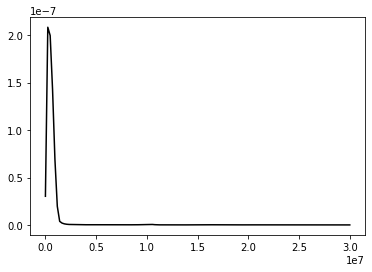

In [18]:
## Saving Images - PSD
image_folder = "IMG_PSD_"+str(n_per_seg)+"/"
try:
    os.mkdir(features_folder+image_folder)
except:
    print('folder already exists')
N = len(DRONES)
F_PSD_freq = np.array(F_PSD_freq)
for n in range(N):
    plt.clf()
    plt.plot(F_PSD_freq[n], F_PSD[n], 'k')
    img_name = features_folder+image_folder+DRONES[n]+'_'+CONDS[n]+'_'+INTS[n]+'.jpg'
    plt.savefig(img_name)

In [ ]:
## Saving Spectrogram - Arrays

# CHOOSE FEATURES
Xs = F_SPEC

# change lists to arrays and make it stackable
Xs_arr = np.array(Xs)
Xs_arr.shape

# labels
y_drones_arr = np.array(DRONES)
y_conds_arr = np.array(CONDS)
y_ints_arr = np.array(INTS)

data_save = {'feat': Xs_arr, 'drones': y_drones_arr, 'conds': y_conds_arr, 'ints': y_ints_arr}

#Save data
# date_string = date.today()
# np.save(features_folder+"SPEC_"+str(n_per_seg)+"_"+str(date_string), data_save)


In [ ]:
## Saving Images - SPEC
image_folder = "IMG_SPEC_"+str(n_per_seg)+"/"
try:
    os.mkdir(features_folder+image_folder)
except:
    print('folder already exists')
N = len(DRONES)
F_PSD_freq = np.array(F_PSD_freq)
for n in range(N):
    plt.clf()
    plt.pcolormesh(F_SPEC_time[n], F_SPEC_freq[n], F_SPEC[n], cmap='Greys', vmin=Sxx.min(), vmax=Sxx.max())
    img_name = features_folder+image_folder+DRONES[n]+'_'+CONDS[n]+'_'+INTS[n]+'.jpg'
    plt.savefig(img_name)

### Visualize Signals

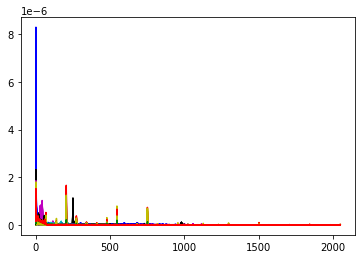

In [7]:
# plot for each type of drone
X_norm = Xs
for n in range(len(Xs_arr)):
    if DRONES[n] == 'AIR':
        c = 'r'
    elif DRONES[n] == 'DIS':
        c = 'b'
    elif DRONES[n] == 'INS':
        c = 'g'
    elif DRONES[n] == 'MIN':
        c = 'c'
    elif DRONES[n] == 'MP1':
        c = 'm'
    elif DRONES[n] == 'MP2':
        c = 'k'
    elif DRONES[n] == 'PHA':
        c = 'y'
    
    # normalize it
#     X_norm[n] = Xs[n]/max(Xs[n])
    plt.plot(Xs[n],color=c)